In [2]:
#加载包
import numpy as np
import pandas as pd
from plotnine import*
import seaborn as sns
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
#中文显示问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# notebook嵌入图片
%matplotlib inline
# 提高分辨率
%config InlineBackend.figure_format='retina'

# 切分数据
from sklearn.model_selection import train_test_split
# 评价指标
from sklearn.metrics import mean_squared_error
# 交叉检验
from sklearn.model_selection import cross_val_score

# 忽略警告
import warnings
warnings.filterwarnings('ignore')

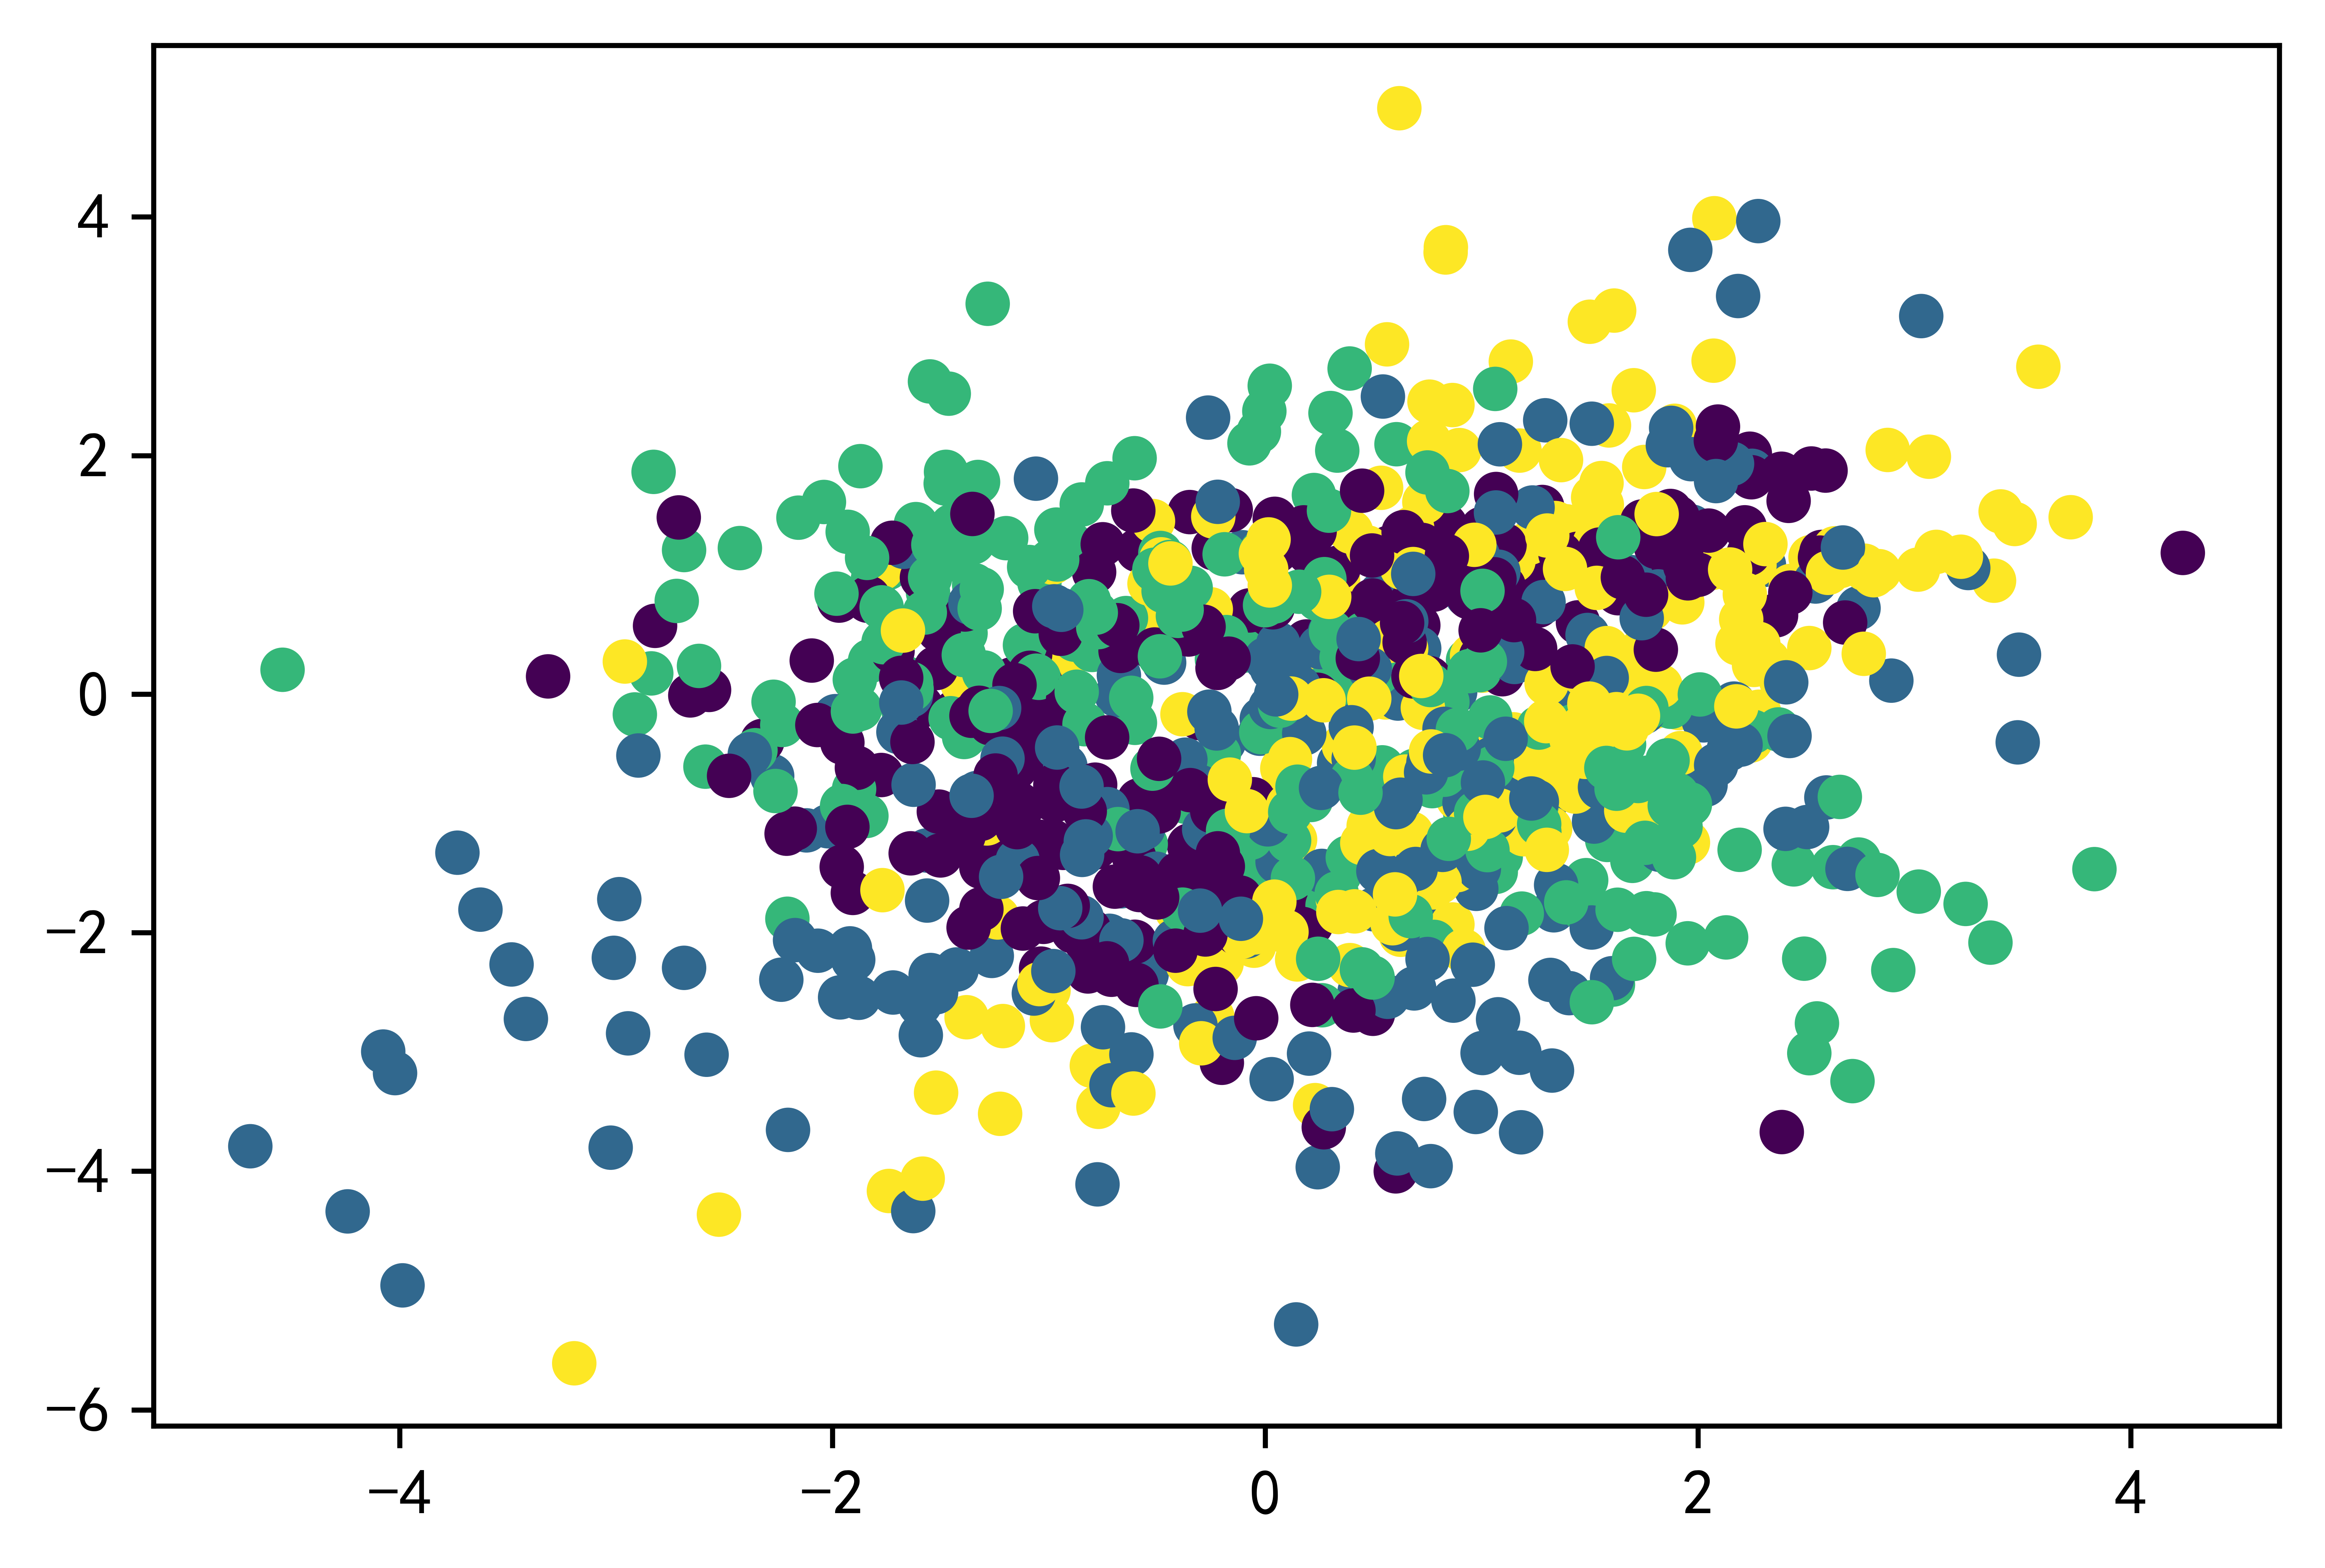

In [3]:
from sklearn.datasets import make_classification

x, y = make_classification(n_samples=1000, # 样本个数
n_features=10, # 特征个数
n_informative=4, # 有效特征个数
n_redundant=3, # 冗余特征个数（有效特征的随机组合）
n_repeated=3, # 重复特征个数（有效特征和冗余特征的随机组合）
n_classes=4, # 样本类别
n_clusters_per_class=2, # 簇的个数
random_state=42)
# 可视化分类数据集，只选择前两个特征
plt.figure(dpi = 600,figsize = (6,4))
plt.scatter(x[:,0],x[:,1],c = y)

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=45, test_size=0.2)

In [5]:
# 随机森林分类
from sklearn.ensemble import RandomForestClassifier
rf_ori = RandomForestClassifier(oob_score=True, random_state=42)
rf_ori.fit(x_train,y_train)
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print('训练集准确率:{:.2f}'.format(accuracy_score(y_train, rf_ori.predict(x_train))))
print('测试集准确率:{:.2f}'.format(accuracy_score(y_test, rf_ori.predict(x_test))))

训练集准确率:1.00
测试集准确率:0.79


In [6]:
import geatpy as ea
from multiprocessing import Pool as ProcessPool
import multiprocessing as mp
from multiprocessing.dummy import Pool as ThreadPool
class MyProblem(ea.Problem): # 继承Problem父类
    def __init__(self,PoolType):
        name = 'MyProblem'  # 初始化name（函数名称，可以随意设置）
        M = 1  # 初始化M（目标维数）
        maxormins = [-1]  # 初始化目标最小最大化标记列表，1：min；-1：max
        Dim = 5  # 初始化Dim（决策变量维数）
        varTypes = [1] * Dim  # 初始化决策变量类型，0：连续；1：离散
        lb = [100,2,2,100,2]  # 决策变量下界
        ub = [600,50,50,1000,10]   # 决策变量上界
        lbin = [1,1,1,1,1]  # 决策变量下边界
        ubin = [1,1,1,1,1]  # 决策变量上边界
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb,ub, lbin, ubin)
        # 这个地方一定要将训练集传给类变量
        self.data = x_train
        self.dataTarget = y_train
        # 设置用多线程还是多进程
        self.PoolType = PoolType
        if self.PoolType == 'Thread':
            self.pool = ThreadPool(2)  # 设置池的大小
        elif self.PoolType == 'Process':
            num_cores = int(mp.cpu_count())  # 获得计算机的核心数
            self.pool = ProcessPool(num_cores)  # 设置池的大小
    def evalVars(self, Vars):  # 目标函数，采用多线程加速计算
        N = Vars.shape[0]
        args = list(zip(list(range(N)),[Vars] * N,[self.data] * N,[self.dataTarget] * N))
        if self.PoolType == 'Thread':
            f = np.array(list(self.pool.map(subAimFunc, args)))
        elif self.PoolType == 'Process':
            result = self.pool.map_async(subAimFunc, args)
            result.wait()
            f = np.array(result.get())
        return f
def subAimFunc(args):
    i = args[0]
    Vars = args[1]
    data = args[2]
    dataTarget = args[3]
    rf_model = RandomForestClassifier(n_estimators = Vars[i, 0],
                                      min_samples_split = Vars[i, 1],
                                      min_samples_leaf = Vars[i, 2],
                                      max_leaf_nodes = Vars[i, 3],
                                      max_features = Vars[i, 4],
                                      random_state=42,
                                      oob_score = True).fit(data,dataTarget)
    scores = cross_val_score(rf_model,data,dataTarget,scoring='f1_macro',cv=10)  # 计算交叉验证的得分
    ObjV_i = [scores.mean()]  # 把交叉验证的平均得分作为目标函数值
    return ObjV_i

gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   50   | 7.63456E-01 | 7.63456E-01 | 6.63074E-01 | 5.59779E-01 | 5.55241E-02 
 1 |  100   | 7.65813E-01 | 7.65813E-01 | 7.02803E-01 | 5.80587E-01 | 5.08094E-02 
 2 |  150   | 7.71180E-01 | 7.71180E-01 | 7.31065E-01 | 6.00939E-01 | 3.70779E-02 
 3 |  200   | 7.77162E-01 | 7.77162E-01 | 7.44891E-01 | 6.25773E-01 | 2.97470E-02 
 4 |  250   | 7.77162E-01 | 7.77162E-01 | 7.58992E-01 | 6.69218E-01 | 1.90449E-02 
 5 |  300   | 7.77162E-01 | 7.77162E-01 | 7.65965E-01 | 6.96988E-01 | 1.26191E-02 
 6 |  350   | 7.78355E-01 | 7.78355E-01 | 7.69503E-01 | 7.38035E-01 | 7.39121E-03 
 7 |  400   | 7.78355E-01 | 7.78355E-01 | 7.71519E-01 | 7.38035E-01 | 6.60158E-03 
 8 |  450   | 7.79605E-01 | 7.79605E-01 | 7.72785E-01 | 7.38035E-01 | 6.36079E-03 
 9 |  500   | 7.79605E-01 | 7.79605E-01 | 7.74861E-01 | 7.68381E-01 | 2.17490E-03 
 10|

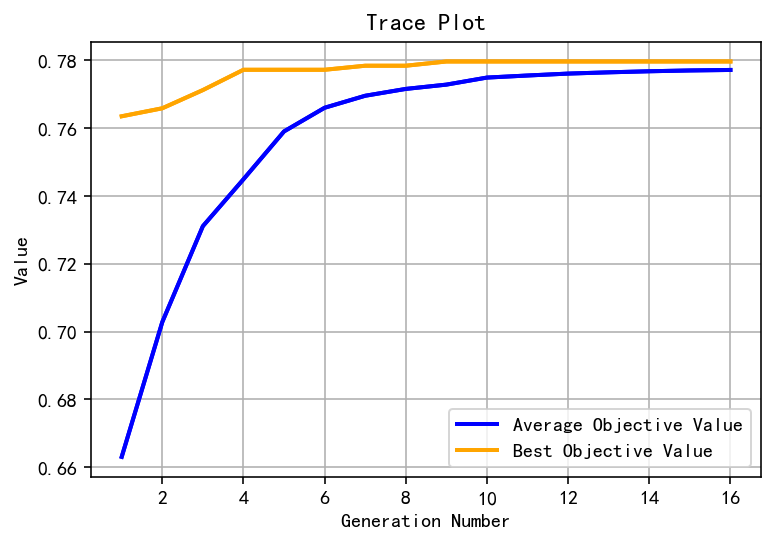

评价次数：800
时间花费 4275.746210098267 秒
最优的目标函数值为：0.7796046108189748
最优的控制变量值为：
292
2
2
100
5


In [7]:
"""============================实例化问题对象========================"""
problem = MyProblem(PoolType='Thread') # 实例化问题对象
"""==============================种群设置==========================="""
Encoding = 'RI' # 编码方式
NIND = 50 # 种群规模
Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges,problem.borders) # 创建区域描述器
population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被真正初始化，仅仅是生成一个种群对象）
"""===========================算法参数设置=========================="""
myAlgorithm = ea.soea_DE_best_1_L_templet(problem, population) # 实例化算法模板对象
myAlgorithm.selFunc = 'ecs' # 采用精英复制选择
myAlgorithm.MAXGEN = 30 # 最大进化代数
myAlgorithm.mutOper.F = 0.5 # 差分进化中的参数F
myAlgorithm.recOper.XOVR = 0.7 # 设置交叉概率
myAlgorithm.logTras = 1 # 设置每隔多少代记录日志，若设置成0则表示不记录日志
myAlgorithm.verbose = True # 设置是否打印输出日志信息
myAlgorithm.trappedValue=1e-6  # 单目标优化陷入停滞的判断阈值。
myAlgorithm.maxTrappedCount=10  # 进化停滞计数器最大上限值。
myAlgorithm.drawing = 1 # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）
"""==========================调用算法模板进行种群进化==============="""
[BestIndi, population] = myAlgorithm.run() # 执行算法模板，得到最优个体以及最后一代种群
BestIndi.save() # 把最优个体的信息保存到文件中
"""=================================输出结果======================="""
print('评价次数：%s' % myAlgorithm.evalsNum)
print('时间花费 %s 秒' % myAlgorithm.passTime)
if BestIndi.sizes != 0:
    print('最优的目标函数值为：%s' % BestIndi.ObjV[0][0])
    print('最优的控制变量值为：')
    count = 0
    for i in range(BestIndi.Phen.shape[1]):
        print(BestIndi.Phen[0, i])
else:
    print('此次未找到可行解。')

In [8]:
rf_new = RandomForestClassifier(n_estimators = 292,
                                min_samples_split = 2,
                                min_samples_leaf = 2,
                                max_leaf_nodes = 100,
                                max_features = 5,
                                random_state= 42,
                                oob_score = True)
rf_new.fit(x_train,y_train)
from sklearn.metrics import accuracy_score
print('训练集准确率:{:.2f}'.format(accuracy_score(y_train, rf_new.predict(x_train))))
print('测试集准确率:{:.2f}'.format(accuracy_score(y_test, rf_new.predict(x_test))))

训练集准确率:0.97
测试集准确率:0.82
